In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# path="/content/drive/MyDrive/Research/SDC/dataset_4/m_100_size_100/run_sc_both_1_sclaed_1_"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [4]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [5]:
x = np.zeros((5000,2))

In [6]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [7]:
x[idx[0]][0], x[idx[2]][5] 

(array([4.04729858, 6.43185741]), array([4.46762703, 4.2460364 ]))

In [8]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [9]:
idx= []
for i in range(10):
  idx.append(y==i)

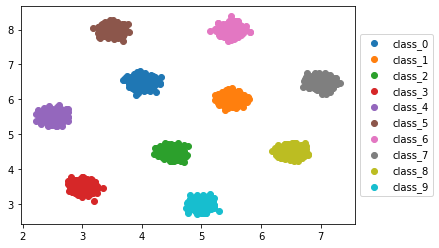

In [10]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
x = ( x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


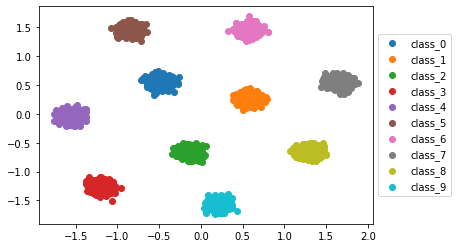

In [12]:

for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [13]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [14]:
desired_num = 1100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,100)
    a = []
    for i in range(100):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(100,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████| 1100/1100 [00:07<00:00, 148.22it/s]


In [15]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [16]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [17]:
batch = 100
msd1 = MosaicDataset(mosaic_list_of_images[0:100], mosaic_label[0:100] , fore_idx[0:100])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [18]:
data,_,_=iter(train_loader).next()

In [19]:
data.shape

torch.Size([100, 100, 2])

In [20]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[100:], mosaic_label[100:] , fore_idx[100:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [21]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,50, bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(50, 1, bias=False)
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)
        
  
        alpha = F.softmax(alp1,dim=1)
        y = torch.sum(alpha*ft1,dim=1)
        #print(alpha.shape,y.shape)
        alpha =alpha[:,:,0]

        return alpha,y   # return  alpha values,attended data
  
    
    def helper(self, x):
      x1 = x
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x,x1

In [22]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 50)
    #self.fc2 = nn.Linear(50,100)
    self.fc2 = nn.Linear(50,3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    #torch.nn.init.xavier_normal_(self.fc3.weight)
    #torch.nn.init.zeros_(self.fc3.bias)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc2(x))
    x = self.fc2(x)
    # print(x.shape)
    return x
  def interpolate(self,x):

    #print(x[0])
    x_norm = torch.linalg.norm(x,dim=1)



    lambda_x = 0.99*(torch.exp(-x_norm))  + 0.01
    # 0.99 torch.exp(-0.1*x_norm) +0.01


    #print(lambda_x.shape)
    output = self.forward(x)


    output = F.softmax(output,dim=1)


    #print("dfdf",output.shape)
    g_x = torch.tensor(np.array([0.33,0.33,0.34])).repeat(x.size(0),1).to(device)

    #print("Flag 1",lambda_x,output)
    
    h_x = torch.mul(lambda_x[:,None],g_x)  +     torch.mul(1-lambda_x[:,None],output)




    #print("Flag 2",torch.mul(lambda_x[:,None],output))
    #print("Flag 3",torch.mul(1-lambda_x[:,None],g_x))
    return h_x

In [23]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [24]:
torch.manual_seed(12)
classify = Classification().double()
classify.load_state_dict(torch.load("/content/drive/MyDrive/Research/sin_cin_trained/dataset_4/1-hidden_50/focus_only/run_sc_m_100_size_100.pt"))
classify = classify.to("cuda")

In [25]:
# def scaled_weights(m):
#     if isinstance(m, nn.Linear):
#         k = 1
#         m.weight.data = m.weight.data/k
#         m.bias.data = m.bias.data/k

In [26]:
# k  = 1
# classify.fc2.weight.data = classify.fc2.weight.data/k
# classify.fc2.bias.data = classify.fc2.bias.data/k

In [27]:
# classify.apply(scaled_weights)

In [28]:
for p in classify.parameters():
  p.requires_grad = False

In [29]:
for p in classify.parameters():
  print(p.requires_grad)

False
False
False
False


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


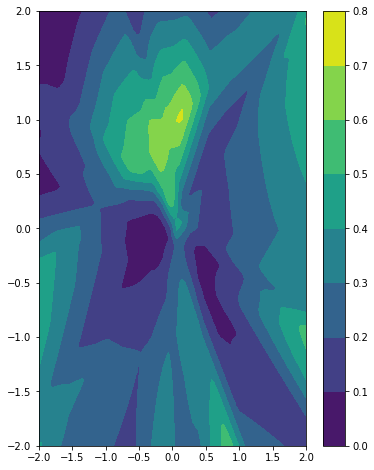

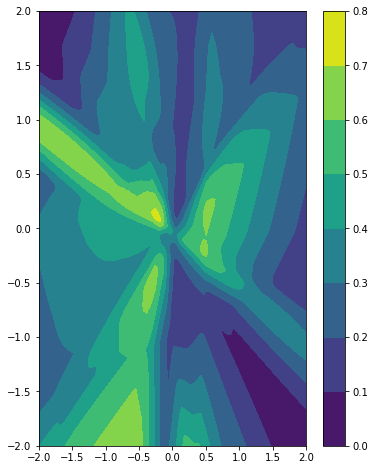

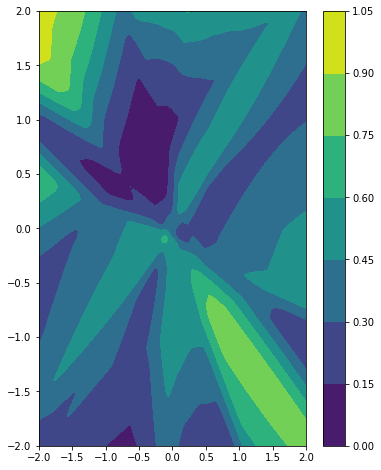

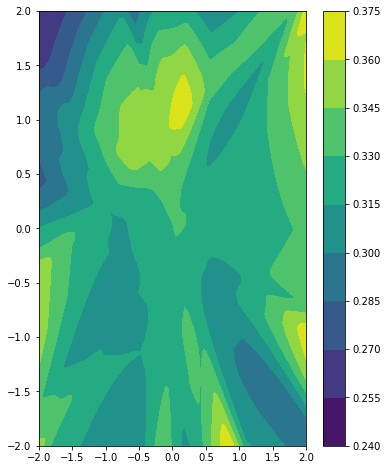

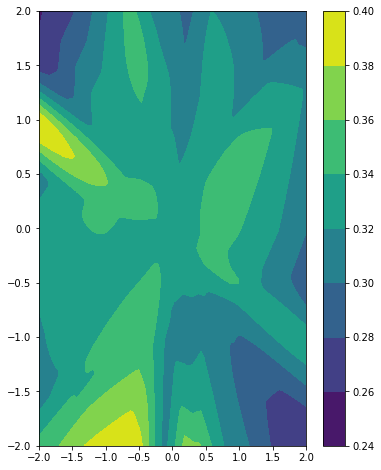

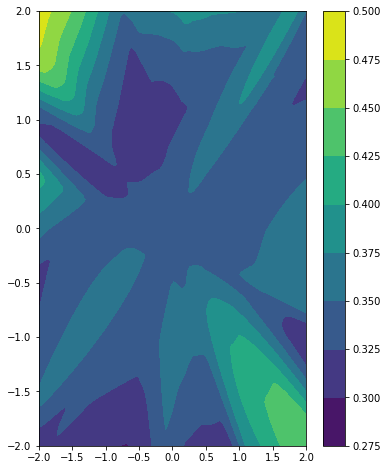

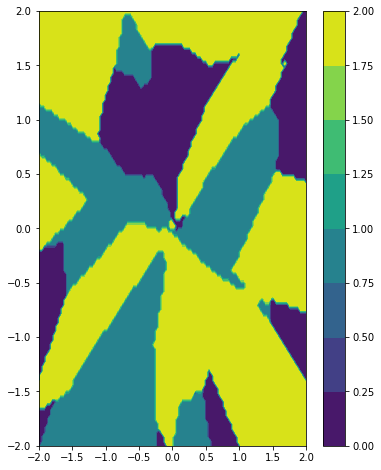

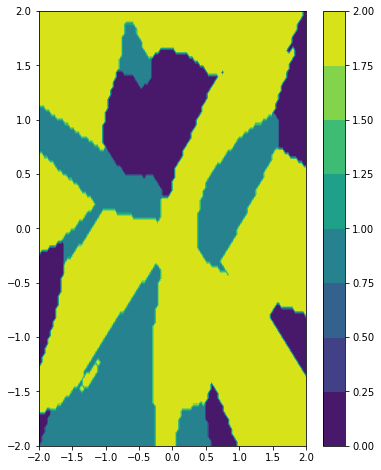

In [30]:
X,Y = torch.meshgrid(torch.linspace(-2, 2,100),torch.linspace(-2, 2, 100))



n=X.shape[0]*X.shape[1]
data = torch.zeros((n,2)).double()
#print(data.shape)
data[:,0]=X.reshape((-1,))
data[:,1]=Y.reshape((-1,))
#print(data.shape)
data = torch.tensor(data).double()
data = data.to("cuda")

with torch.no_grad():
  #alphas, avg_data = focus_net(data)
  outputs = classify(data)
  outputs_hx = classify.interpolate(data)
  #print(outputs,outputs_hx)

outputs = F.softmax(outputs,dim=1)


plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,outputs[:,0].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,outputs[:,1].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)
#scatter = plt.scatter(datx[:,0] ,datx[:,1],c=labelsx,cmap=plt.cm.Paired,alpha=0.8)
#plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,outputs[:,2].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)




_, predicted = torch.max(outputs.data, 1)
_,predicted_hx = torch.max(outputs_hx.data,1)



Z = predicted.cpu().numpy().reshape(X.shape)
Z_hx = outputs_hx
#print(outputs_hx.shape)

#scatter = plt.scatter(datx[:,0] ,datx[:,1],c=labelsx,cmap=plt.cm.Paired,alpha=0.8)
# plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])


plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z_hx[:,0].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z_hx[:,1].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)
#scatter = plt.scatter(datx[:,0] ,datx[:,1],c=labelsx,cmap=plt.cm.Paired,alpha=0.8)
#plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z_hx[:,2].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)
#scatter = plt.scatter(datx[:,0] ,datx[:,1],c=labelsx,cmap=plt.cm.Paired,alpha=0.8)
#plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])



#print(set(predicted.cpu().numpy()))
plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z)
plt.colorbar(cax)

Z_hx = predicted_hx.cpu().numpy().reshape(X.shape)

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z_hx)
plt.colorbar(cax)

#scatter = plt.scatter(tr_attended_data[:,0] ,tr_attended_data[:,1],c=tr_at_labels,cmap=plt.cm.Paired,alpha=0.8)

#plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])

In [31]:
import torch.optim as optim
criterion = nn.NLLLoss()
#optimizer_classify = optim.Adam(classify.parameters(), lr=0.08 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

In [32]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [33]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify.interpolate(avg_images)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the train images: 36.000000 %
total correct 36
total train set images 100
focus_true_pred_true 0 =============> FTPT : 0.000000 %
focus_false_pred_true 36 =============> FFPT : 36.000000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 64 =============> FFPF : 64.000000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  100
100


In [34]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify.interpolate(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the test images: 33.100000 %
total correct 331
total train set images 1000
focus_true_pred_true 0 =============> FTPT : 0.000000 %
focus_false_pred_true 331 =============> FFPT : 33.100000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 669 =============> FFPF : 66.900000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


In [35]:
nos_epochs = 2000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify.interpolate(avg_images)
    outputs = torch.log(outputs)


    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()

    running_loss += loss.item()
    mini = 1
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 1 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;

  if epoch % 1 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        batch = inputs.size(0)
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify.interpolate(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

[1,     1] loss: 1.091
[2,     1] loss: 1.082
[3,     1] loss: 1.076
[4,     1] loss: 1.081
[5,     1] loss: 1.082
[6,     1] loss: 1.080
[7,     1] loss: 1.077
[8,     1] loss: 1.078
[9,     1] loss: 1.077
[10,     1] loss: 1.077
[11,     1] loss: 1.077
[12,     1] loss: 1.078
[13,     1] loss: 1.079
[14,     1] loss: 1.077
[15,     1] loss: 1.076
[16,     1] loss: 1.076
[17,     1] loss: 1.077
[18,     1] loss: 1.077
[19,     1] loss: 1.077
[20,     1] loss: 1.076
[21,     1] loss: 1.076
[22,     1] loss: 1.076
[23,     1] loss: 1.075
[24,     1] loss: 1.074
[25,     1] loss: 1.074
[26,     1] loss: 1.075
[27,     1] loss: 1.074
[28,     1] loss: 1.073
[29,     1] loss: 1.074
[30,     1] loss: 1.074
[31,     1] loss: 1.074
[32,     1] loss: 1.073
[33,     1] loss: 1.073
[34,     1] loss: 1.074
[35,     1] loss: 1.073
[36,     1] loss: 1.073
[37,     1] loss: 1.073
[38,     1] loss: 1.073
[39,     1] loss: 1.073
[40,     1] loss: 1.073
[41,     1] loss: 1.073
[42,     1] loss: 1.072
[

In [36]:
#torch.save(focus_net.state_dict(),path+"_focus.pt")
#torch.save(classify.state_dict(),path+"_classify.pt")

In [37]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [38]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [39]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [40]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,100,0,36,0,64
1,1,0,100,0,36,0,64
2,2,0,100,0,35,0,65
3,3,0,100,0,44,0,56
4,4,0,100,0,39,0,61
...,...,...,...,...,...,...,...
1996,1996,0,100,0,42,0,58
1997,1997,0,100,0,43,0,57
1998,1998,0,100,0,42,0,58
1999,1999,0,100,0,43,0,57


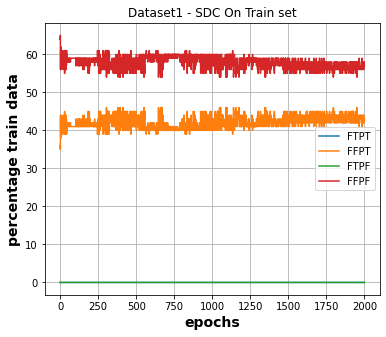

In [41]:
num  = 1
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/num, label ="FTPT")
plt.plot(col1,np.array(col5)/num, label ="FFPT")
plt.plot(col1,np.array(col6)/num, label ="FTPF")
plt.plot(col1,np.array(col7)/num, label ="FFPF")
plt.title("Dataset1 - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
#plt.savefig(path+"_train.png", bbox_inches="tight")
#plt.savefig(path+"_train.pdf", bbox_inches="tight")
#plt.savefig(path+"_train.png", bbox_inches="tight")
#plt.savefig(path+"_train.pdf", bbox_inches="tight")
plt.show()

In [42]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,0,331,0,669
1,1,0,1000,0,320,0,680
2,2,0,1000,0,318,0,682
3,3,0,1000,0,344,0,656
4,4,0,1000,0,348,0,652
...,...,...,...,...,...,...,...
1996,1996,0,1000,0,318,0,682
1997,1997,0,1000,0,321,0,679
1998,1998,0,1000,0,319,0,681
1999,1999,0,1000,0,319,0,681


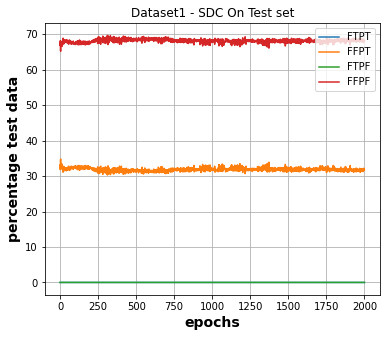

In [43]:
num = 10
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/num, label ="FTPT")
plt.plot(col1,np.array(col11)/num, label ="FFPT")
plt.plot(col1,np.array(col12)/num, label ="FTPF")
plt.plot(col1,np.array(col13)/num, label ="FFPF")
plt.title("Dataset1 - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
#plt.savefig(path+"_test.png", bbox_inches="tight")
#plt.savefig(path+"_test.pdf", bbox_inches="tight")
#plt.savefig(path+"_test.png", bbox_inches="tight")
#plt.savefig(path+"_test.pdf", bbox_inches="tight")
plt.show()

In [45]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify.interpolate(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the train images: 42.000000 %
total correct 42
total train set images 100
focus_true_pred_true 0 =============> FTPT : 0.000000 %
focus_false_pred_true 42 =============> FFPT : 42.000000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 58 =============> FFPF : 58.000000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  100


In [46]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify.interpolate(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the test images: 31.800000 %
total correct 318
total train set images 1000
focus_true_pred_true 0 =============> FTPT : 0.000000 %
focus_false_pred_true 318 =============> FFPT : 31.800000 %
focus_true_pred_false 0 =============> FTPF : 0.000000 %
focus_false_pred_false 682 =============> FFPF : 68.200000 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


In [47]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify.interpolate(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 42.000000 %
total correct 42
total train set images 100


In [48]:
correct = 0
total = 0
tr_attended_data = []
tr_at_labels =[]

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    tr_attended_data.append(avg_images.cpu().numpy())
    outputs = classify.interpolate(avg_images)
    tr_at_labels.append(labels.cpu().numpy())

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
#print("total correct", correct)
#print("total train set images", total)

In [49]:
tr_attended_data = np.concatenate(tr_attended_data,axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


torch.Size([10000, 3])


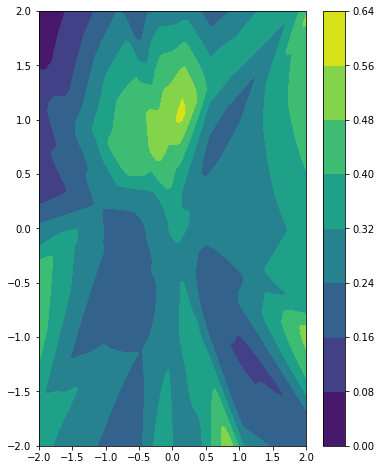

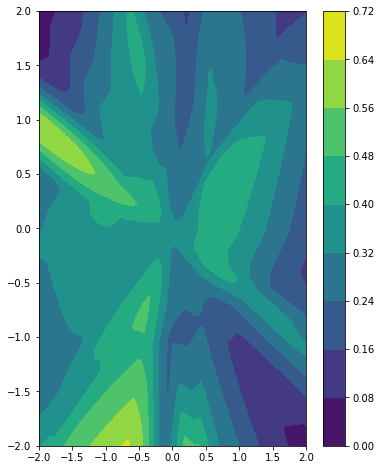

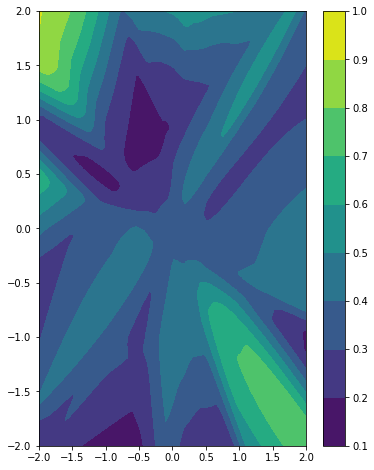

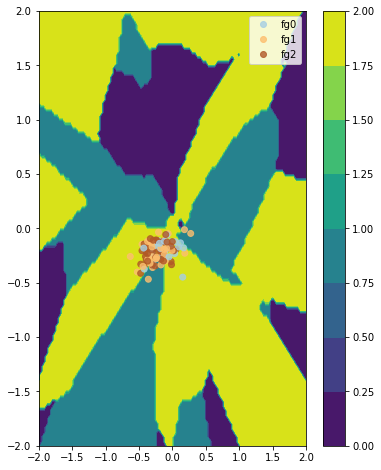

In [52]:
X,Y = torch.meshgrid(torch.linspace(-2, 2,100),torch.linspace(-2, 2, 100))



n=X.shape[0]*X.shape[1]
data = torch.zeros((n,2)).double()
#print(data.shape)
data[:,0]=X.reshape((-1,))
data[:,1]=Y.reshape((-1,))
#print(data.shape)
data = torch.tensor(data).double()
data = data.to("cuda")

with torch.no_grad():
  #alphas, avg_data = focus_net(data)
  outputs = classify.interpolate(data)
_, predicted = torch.max(outputs.data, 1)


Z = outputs
print(Z.shape)



plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z[:,0].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z[:,1].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)
#scatter = plt.scatter(datx[:,0] ,datx[:,1],c=labelsx,cmap=plt.cm.Paired,alpha=0.8)
#plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])

plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z[:,2].cpu().numpy().reshape(X.shape))
plt.colorbar(cax)

Z = predicted.cpu().numpy().reshape(X.shape)





plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z)
plt.colorbar(cax)

scatter = plt.scatter(tr_attended_data[:,0] ,tr_attended_data[:,1],c=tr_at_labels,cmap=plt.cm.Paired,alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])

torch.Size([10000, 2])
torch.Size([10000, 2])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


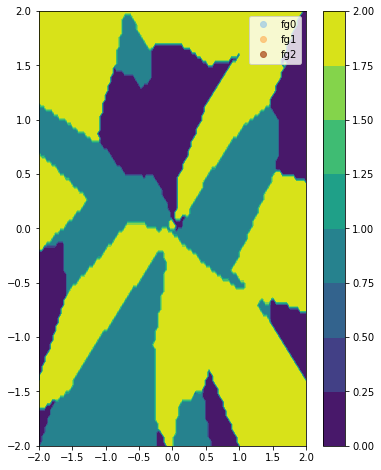

In [50]:
X,Y = torch.meshgrid(torch.linspace(-2, 2,100),torch.linspace(-2, 2, 100))



n=X.shape[0]*X.shape[1]
data = torch.zeros((n,2)).double()
print(data.shape)
data[:,0]=X.reshape((-1,))
data[:,1]=Y.reshape((-1,))
print(data.shape)
data = torch.tensor(data).double()
data = data.to("cuda")

with torch.no_grad():
  #alphas, avg_data = focus_net(data)
  outputs = classify(data)
_, predicted = torch.max(outputs.data, 1)

Z = predicted.cpu().numpy().reshape(X.shape)
plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z)
plt.colorbar(cax)

#scatter = plt.scatter(tr_attended_data[:,0] ,tr_attended_data[:,1],c=tr_at_labels,cmap=plt.cm.Paired,alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])

In [51]:
correct = 0
total = 0
attended_data = []
at_labels =[]

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    attended_data.append(avg_images.cpu().numpy())
    outputs = classify(avg_images)
    at_labels.append(labels.cpu().numpy())

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 32.900000 %
total correct 329
total train set images 1000


In [52]:
attended_data = np.concatenate(attended_data,axis=0)

torch.Size([10000, 2])
torch.Size([10000, 2])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


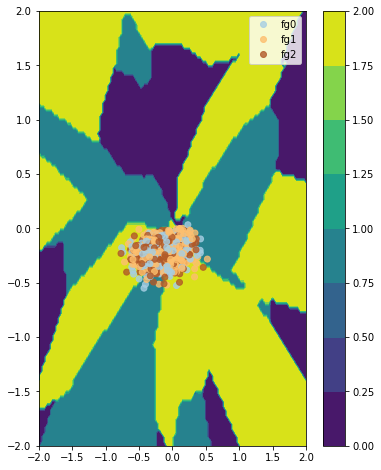

In [53]:
X,Y = torch.meshgrid(torch.linspace(-2, 2,100),torch.linspace(-2, 2, 100))



n=X.shape[0]*X.shape[1]
data = torch.zeros((n,2)).double()
print(data.shape)
data[:,0]=X.reshape((-1,))
data[:,1]=Y.reshape((-1,))
print(data.shape)
data = torch.tensor(data).double()
data = data.to("cuda")

with torch.no_grad():
  #alphas, avg_data = focus_net(data)
  outputs = classify(data)
_, predicted = torch.max(outputs.data, 1)

Z = predicted.cpu().numpy().reshape(X.shape)
plt.figure(figsize=(6,8))
cax = plt.contourf(X,Y,Z)
plt.colorbar(cax)

scatter = plt.scatter(attended_data[:,0] ,attended_data[:,1],c=at_labels,cmap=plt.cm.Paired,alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=["fg0","fg1","fg2"])